# FIFA19

   URL : https://www.kaggle.com/karangadiya/fifa19

   The dataset contains the detailed attributes for every player registered in the latest edition of FIFA 19 database.

   Number of Instances: 18207

   Attribute Characteristics: numeric, categorical

   Number of Attributes: 89

   Missing Values: N/A

   The target variable is the *Release Clause*.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from datetime import datetime
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import seaborn as sns

%matplotlib inline

In [2]:
fifa_data = pd.read_csv("Fifa19.csv", sep=',', index_col=False)

In [3]:
fifa_data.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


We will drop unnecessary attributes like Unnamed, ID, Photo, Flag, Club Logo, Name, Body Type LS, ST, RS, LW, LF, CF, RF, RW, LAM, CAM, RAM, LM, LCM, CM, RCM, RM, LWB, LDM, CDM, RDM, RWB, LB, LCB, CB, RCB and RB.

In [4]:
fifa_data.drop(fifa_data.iloc[:, 0:2], axis=1, inplace=True)
fifa_data.drop(fifa_data.iloc[:, 26:52], axis=1, inplace=True)
fifa_data.drop(['Photo', 'Flag', 'Club Logo'], axis=1, inplace=True)

In [5]:
fifa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 58 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      18207 non-null  object 
 1   Age                       18207 non-null  int64  
 2   Nationality               18207 non-null  object 
 3   Overall                   18207 non-null  int64  
 4   Potential                 18207 non-null  int64  
 5   Club                      17966 non-null  object 
 6   Value                     18207 non-null  object 
 7   Wage                      18207 non-null  object 
 8   Special                   18207 non-null  int64  
 9   Preferred Foot            18159 non-null  object 
 10  International Reputation  18159 non-null  float64
 11  Weak Foot                 18159 non-null  float64
 12  Skill Moves               18159 non-null  float64
 13  Work Rate                 18159 non-null  object 
 14  Body T

In [6]:
dups = fifa_data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


In [7]:
print("Total missing values:", fifa_data.isna().sum().sum())
fifa_data.isna().sum().sort_values(ascending=False)

Total missing values: 22774


Loaned From                 16943
Release Clause               1564
Joined                       1553
Contract Valid Until          289
Club                          241
Position                       60
Jersey Number                  60
Weight                         48
Curve                          48
GKReflexes                     48
Volleys                        48
ShortPassing                   48
HeadingAccuracy                48
Finishing                      48
Crossing                       48
Preferred Foot                 48
Height                         48
International Reputation       48
LongPassing                    48
Real Face                      48
Body Type                      48
Work Rate                      48
Skill Moves                    48
Weak Foot                      48
FKAccuracy                     48
Dribbling                      48
BallControl                    48
Positioning                    48
GKPositioning                  48
GKKicking     

### Handling missing data

- If we remove all the missing values from `Release Clause` variable then the `Loaned From` variable will be blank therefore we need to drop it

In [8]:
# Handle missing data
fifa_data.drop(["Loaned From"], axis=1, inplace=True)
fifa_data.drop(fifa_data[fifa_data["Release Clause"].isna()].index, inplace=True)

Value, Wage, Release Clause, Weight, Height → These variables contain characters such as $, €, K, M, lbs and ‘ that have to be removed. The K and M characters will be replaced with 1e3 and 1e6 respectively. After removing and replacing, we will convert these variables to float so that we can analyze them later.

In [9]:
fifa_data[["Value", "Wage", "Height", "Weight", "Release Clause"]].head(5)

,Value,Wage,Height,Weight,Release Clause
0,€110.5M,€565K,5'7,159lbs,€226.5M
1,€77M,€405K,6'2,183lbs,€127.1M
2,€118.5M,€290K,5'9,150lbs,€228.1M
3,€72M,€260K,6'4,168lbs,€138.6M
4,€102M,€355K,5'11,154lbs,€196.4M


In [10]:
# Replacing [Euro Sign], lbs, ' and converting M, K, B to numerical values
fifa_data['Value'] = fifa_data['Value'].replace('\u20AC','',regex=True)
fifa_data['Wage'] = fifa_data['Wage'].replace('\u20AC','',regex=True)
fifa_data['Height'] = fifa_data['Height'].replace('\'', '.', regex=True)
fifa_data['Weight'] = fifa_data['Weight'].replace("lbs", "", regex=True)
fifa_data['Release Clause'] = fifa_data['Release Clause'].replace('\u20AC','',regex=True)

repl_dict = {'[kK]': '*1e3', '[mM]': '*1e6', '[bB]': '*1e9'}
fifa_data['Value'] = fifa_data['Value'].replace(repl_dict, regex=True).map(pd.eval).astype(float)
fifa_data['Wage'] = fifa_data['Wage'].replace(repl_dict, regex=True).map(pd.eval).astype(float)
fifa_data['Release Clause'] = fifa_data['Release Clause'].replace(repl_dict, regex=True).map(pd.eval).astype(float)

In [11]:
fifa_data[["Value", "Wage", "Height", "Weight", "Release Clause"]].head(5)

,Value,Wage,Height,Weight,Release Clause
0,110500000.0,565000.0,5.7,159,226500000.0
1,77000000.0,405000.0,6.2,183,127100000.0
2,118500000.0,290000.0,5.9,150,228100000.0
3,72000000.0,260000.0,6.4,168,138600000.0
4,102000000.0,355000.0,5.11,154,196400000.0


In [12]:
# Create new columns Joined_Date and Joined_Moth from the Joined datetime attribute, by separating it
fifa_data['Joined'] = pd.to_datetime(fifa_data['Joined'])
fifa_data['Joined_Date'] = fifa_data['Joined'].dt.year.astype('category')
fifa_data['Joined_Month'] = fifa_data['Joined'].dt.month.astype('category')

# Drop Joined column since we don't need it anymore
fifa_data.drop(['Joined'], axis=1, inplace=True)

In [13]:
fifa_data.head(10)

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,...,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Joined_Date,Joined_Month
0,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,Left,...,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,2004,7
1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,Right,...,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,2018,7
2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,Right,...,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,2017,8
3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,Right,...,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2011,7
4,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,Right,...,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,2015,8
5,E. Hazard,27,Belgium,91,91,Chelsea,93000000.0,340000.0,2142,Right,...,27.0,22.0,11.0,12.0,6.0,8.0,8.0,172100000.0,2012,7
6,L. Modrić,32,Croatia,91,91,Real Madrid,67000000.0,420000.0,2280,Right,...,76.0,73.0,13.0,9.0,7.0,14.0,9.0,137400000.0,2012,8
7,L. Suárez,31,Uruguay,91,91,FC Barcelona,80000000.0,455000.0,2346,Right,...,45.0,38.0,27.0,25.0,31.0,33.0,37.0,164000000.0,2014,7
8,Sergio Ramos,32,Spain,91,91,Real Madrid,51000000.0,380000.0,2201,Right,...,92.0,91.0,11.0,8.0,9.0,7.0,11.0,104600000.0,2005,8
9,J. Oblak,25,Slovenia,90,93,Atlético Madrid,68000000.0,94000.0,1331,Right,...,12.0,18.0,86.0,92.0,78.0,88.0,89.0,144500000.0,2014,7


In [14]:
fifa_data.describe()

,Age,Overall,Potential,Value,Wage,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
count,16643.000000,16643.000000,16643.000000,1.664300e+04,16643.000000,16643.000000,16643.000000,16643.000000,16643.000000,16643.000000,...,16643.000000,16643.000000,16643.000000,16643.000000,16643.000000,16643.000000,16643.000000,16643.000000,16643.000000,1.664300e+04
mean,25.226221,66.162771,71.140900,2.442667e+06,9618.037613,1595.383404,1.114823,2.942919,2.349516,19.657213,...,58.558673,47.328967,47.776302,45.751607,16.747521,16.515712,16.355765,16.503936,16.837409,4.585061e+06
std,4.716588,7.008236,6.151409,5.720629e+06,22263.518927,275.723076,0.398559,0.659933,0.755855,16.054811,...,11.539260,19.937220,21.681809,21.295201,17.832273,17.033907,16.615668,17.151713,18.090985,1.111872e+07
min,16.000000,46.000000,48.000000,1.000000e+04,1000.000000,731.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.300000e+04
25%,21.000000,62.000000,67.000000,3.000000e+05,1000.000000,1452.000000,1.000000,3.000000,2.000000,8.000000,...,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000,5.250000e+05
50%,25.000000,66.000000,71.000000,6.750000e+05,3000.000000,1633.000000,1.000000,3.000000,2.000000,17.000000,...,59.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000,1.100000e+06
75%,29.000000,71.000000,75.000000,2.000000e+06,8000.000000,1787.000000,1.000000,3.000000,3.000000,26.000000,...,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000,3.500000e+06
max,45.000000,94.000000,95.000000,1.185000e+08,565000.000000,2346.000000,5.000000,5.000000,5.000000,99.000000,...,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000,2.281000e+08


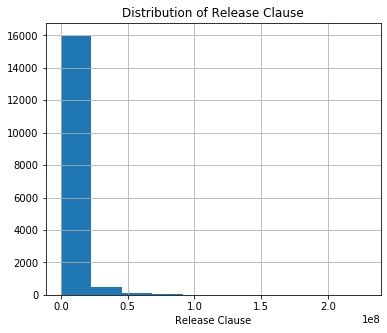

In [15]:
fifa_data["Release Clause"].hist(figsize=(6,5))
plt.xlabel("Release Clause")
plt.title("Distribution of Release Clause")
plt.show()

From the plot we can see that most of the players have a release clause distributed around 0-25M.

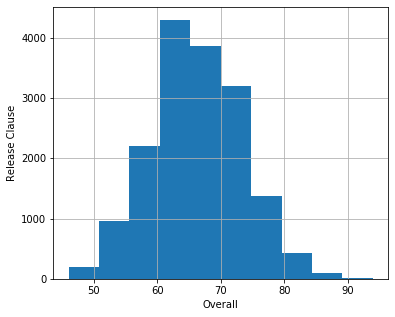

In [16]:
fifa_data["Overall"].hist(figsize=(6,5))
plt.xlabel("Overall")
plt.ylabel("Release Clause")
plt.show()

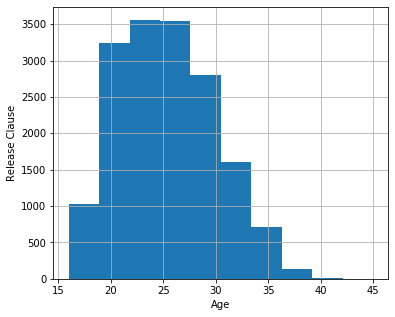

In [17]:
fifa_data["Age"].hist(figsize=(6,5))
plt.xlabel("Age")
plt.ylabel("Release Clause")
plt.show()

- From the plot we can see that players tend to have the highest release clause in the middle of their career and as they grow older it drops

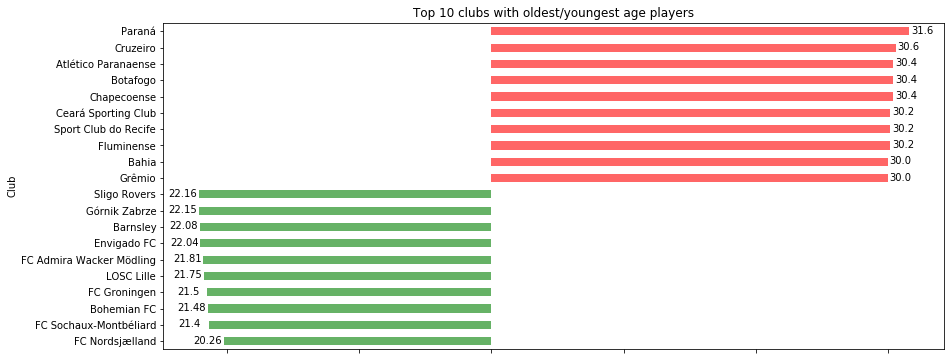

In [18]:
# Prepare Data
clubAge_avg = fifa_data.groupby("Club")["Age"].mean()
oldAgeClubs = clubAge_avg.sort_values(ascending=False).head(10).sort_values(ascending=True)
youngAgeClubs = clubAge_avg.sort_values(ascending=True).head(10).sort_values(ascending=True)
colors = ["green" if x < 0 else "red" for x in np.concatenate([youngAgeClubs * (-1), oldAgeClubs])]
ageClubs = pd.concat([youngAgeClubs * (-1), oldAgeClubs], axis=0)
# Figure size
fig, ax = plt.subplots(figsize=(14,6))
# Set bar labels
position = 0
for i, v in enumerate(youngAgeClubs):
    ax.text((v * (-1)) - 2.3, i - .15, str(round(v, 2)))
    position = i
for i, v in enumerate(oldAgeClubs):
    ax.text(v + .15, (i + position + 1) - .15, str(round(v, 2)))
ax.set_xticklabels([])
# Plot results
ageClubs.plot(kind="barh", title="Top 10 clubs with oldest/youngest age players", color=colors, alpha=0.6)

- Brazilian players tend to retire in Brazil after long careers in Europe, that fact is key to understand the extreme above average age for some of the clubs.

- Nordic countries don’t have a big budget to retain young players, as soon as they prove to be talented they are likely to sign with another club.

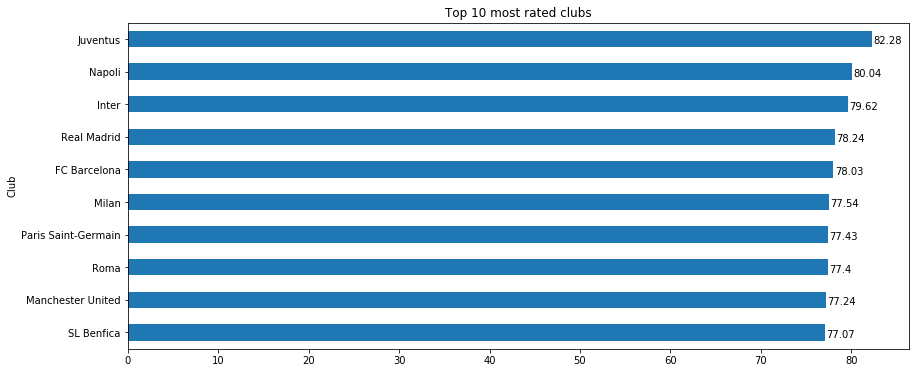

In [19]:
fig, ax = plt.subplots(figsize=(14,6))
topClubs = fifa_data.groupby("Club")["Overall"].mean().sort_values(ascending=False).head(10).sort_values(ascending=True)
for i, v in enumerate(topClubs):
    ax.text(v + .15, i - .15, str(round(v, 2)))
topClubs.plot(kind="barh", title="Top 10 most rated clubs")

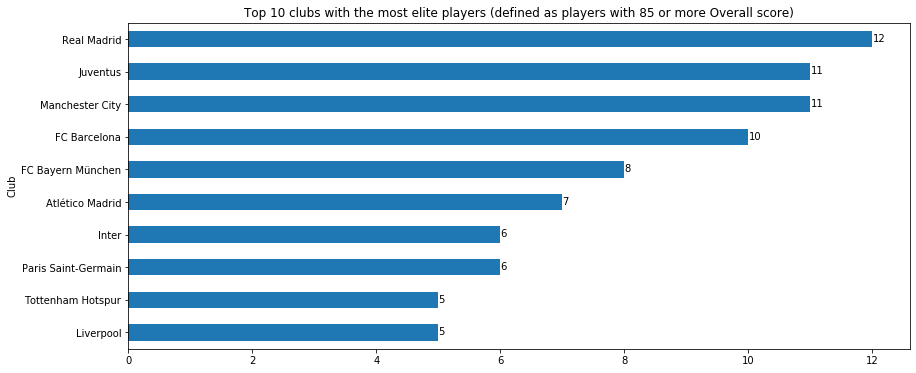

In [20]:
fig, ax = plt.subplots(figsize=(14,6))
topClubs = fifa_data[fifa_data["Overall"] >= 85].groupby("Club")["Overall"].count().sort_values(ascending=False).head(10).sort_values(ascending=True)
for i, v in enumerate(topClubs):
    ax.text(v + .005, i - .07, str(round(v, 2)))
topClubs.plot(kind="barh", title="Top 10 clubs with the most elite players (defined as players with 85 or more Overall score)")

- Even though Juventus is the most rated club, it does not have the most elite players.

In [21]:
print("Total teams =", fifa_data.groupby("Club")["Club"].unique().count())
print("Total players = ", fifa_data.groupby("Name")["Name"].unique().count())
print("Average age of players in the entire dataset = ", round(fifa_data["Age"].mean(), 2))

Total teams = 651
Total players =  15773
Average age of players in the entire dataset =  25.23


In [22]:
print("Top 3 best players:")
print(fifa_data[["Name", "Overall"]].sort_values("Overall", ascending=False).head(3))

Top 3 best players:
                Name  Overall
0           L. Messi       94
1  Cristiano Ronaldo       94
2          Neymar Jr       92


In [23]:
print("Top 3 best young players (defined as players with less than 21 years old):")
print(fifa_data.loc[fifa_data["Age"] < 21, ["Name", "Overall", "Age"]].sort_values(["Overall"], ascending=False).head(3))

Top 3 best young players (defined as players with less than 21 years old):
              Name  Overall  Age
25       K. Mbappé       88   19
229  G. Donnarumma       82   19
226     M. de Ligt       82   18


In [24]:
print("Top 3 most valuable players:")
print(fifa_data[["Name", "Value"]].sort_values("Value", ascending=False).head(3))

Top 3 most valuable players:
           Name        Value
2     Neymar Jr  118500000.0
0      L. Messi  110500000.0
4  K. De Bruyne  102000000.0


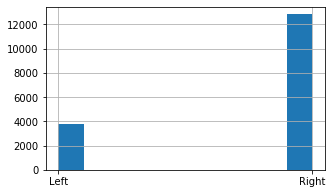

In [25]:
fifa_data["Preferred Foot"].hist(figsize=(5,3))

40% of the players play with their left foot

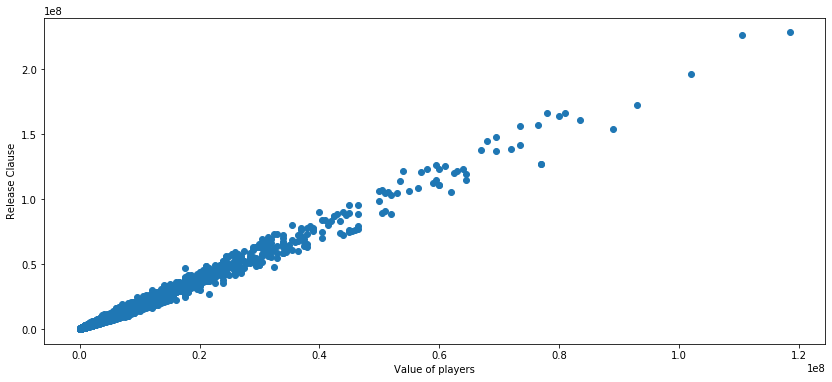

In [26]:
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(fifa_data['Value'], fifa_data["Release Clause"])
ax.set_xlabel('Value of players')
ax.set_ylabel('Release Clause')
plt.show()

From the plot we can see that `Value` is highly correlated with the output variable

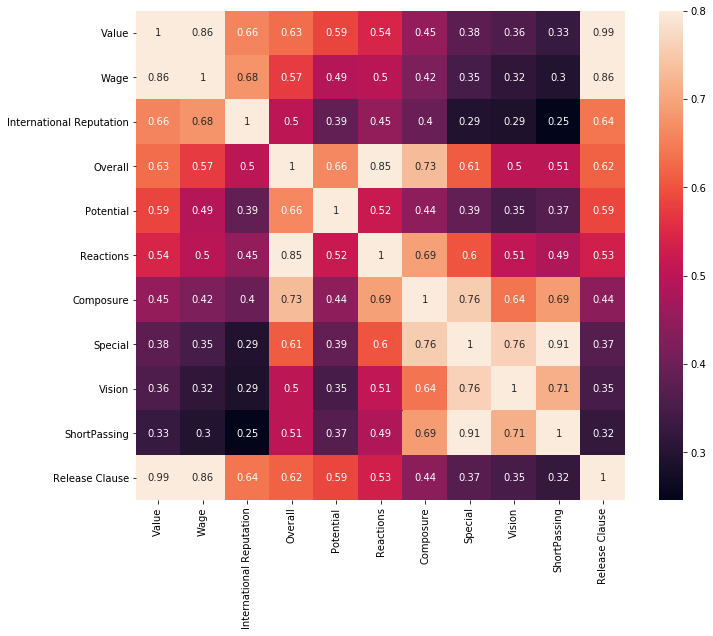

In [27]:
#abs(fifa_data[fifa_data.columns[:]].corr()["Release Clause"][:]).sort_values(ascending=False).head(11)

correlation_matrix = fifa_data[['Value', 'Wage', 'International Reputation', 'Overall', 'Potential', 'Reactions', 'Composure', 'Special', 'Vision', 'ShortPassing', 'Release Clause']].corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True, annot=True)
plt.show()

From the correlation matrix we can see that top 10 variables that have the highest correlation with the output variable `Release Clause`. Also, they are positively correlated with output variable.

In [28]:
# Separating out the features
X = fifa_data.drop(["Release Clause"], axis=1)
# Separating out the target
y = fifa_data["Release Clause"]

print("fifa_data.shape: {} X.shape: {} y.shape: {}".format(fifa_data.shape, X.shape, y.shape))

fifa_data.shape: (16643, 58) X.shape: (16643, 57) y.shape: (16643,)


In [29]:
X.head(5)

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Joined_Date,Joined_Month
0,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,Left,...,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,2004,7
1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,Right,...,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,2018,7
2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,Right,...,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,2017,8
3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,Right,...,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,2011,7
4,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,Right,...,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,2015,8


In [30]:
# Drop unnecessary features
X.drop(["Name"], axis=1, inplace=True)
X.drop(["Body Type"], axis=1, inplace=True)
X.drop(["Real Face"], axis=1, inplace=True)

In [31]:
print('\nPearson correlation coefficients: \n')
n = len(X.columns)
for i in range(n-1):
    for j in range(i+1,n):
        if X[X.columns[i]].dtype in ['int64','float64'] and X[X.columns[j]].dtype in ['int64','float64']:
            c = np.corrcoef(X[X.columns[i]],X[X.columns[j]])
            if abs(c[0,1])>=0.95:
                print(str(X.columns[i])+' and '+str(X.columns[j]) + ":" + str(c[0,1]))


Pearson correlation coefficients: 

StandingTackle and SlidingTackle:0.9747128096533418
GKDiving and GKHandling:0.9706399004266668
GKDiving and GKKicking:0.9659376091226247
GKDiving and GKPositioning:0.9702324953881593
GKDiving and GKReflexes:0.973802576882097
GKHandling and GKKicking:0.9654589559702591
GKHandling and GKPositioning:0.9697864679436284
GKHandling and GKReflexes:0.9706353297028458
GKKicking and GKPositioning:0.9646072244987199
GKKicking and GKReflexes:0.9666342803246996
GKPositioning and GKReflexes:0.970491592383447


In [32]:
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

X_remove_high_corr = trimm_correlated(X, 0.95)

We will remove all those features that are 95% or more correlated with each other, but we will keep one of them.

### Modeling

For testing regression techniques, we will use two train/test splits of data. 
- The first split will contain the all the numeric features (44 in total)
- The second split will contain all the numeric features except for those that are highly correlated with each other. They will be removed therefore in total we will have 39 features to work with from the second split.

In [33]:
randNum = 1234

In [34]:
# Use 75% of the data to train the models and the remaining for testing/validation
X_numeric = X.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
X_train_numeric, X_test_numeric, y_train_numeric, y_test_numeric = train_test_split(X_numeric, y, test_size=0.25, random_state=randNum)
print("X_train_numeric.shape: {} y_train_numeric.shape: {}".format(X_train_numeric.shape, y_train_numeric.shape))
print("X_test_numeric.shape: {} y_test_numeric.shape: {}".format(X_test_numeric.shape, y_test_numeric.shape))

X_train_remove_high_corr, X_test_remove_high_corr, y_train_remove_high_corr, y_test_remove_high_corr = train_test_split(X_remove_high_corr, y, test_size=0.25, random_state=randNum)
print("X_train_remove_high_corr.shape: {} y_train_remove_high_corr.shape: {}".format(X_train_remove_high_corr.shape, y_train_remove_high_corr.shape))
print("X_test_remove_high_corr.shape: {} y_test_remove_high_corr.shape: {}".format(X_test_remove_high_corr.shape, y_test_remove_high_corr.shape))

X_train_numeric.shape: (12482, 44) y_train_numeric.shape: (12482,)
X_test_numeric.shape: (4161, 44) y_test_numeric.shape: (4161,)
X_train_remove_high_corr.shape: (12482, 39) y_train_remove_high_corr.shape: (12482,)
X_test_remove_high_corr.shape: (4161, 39) y_test_remove_high_corr.shape: (4161,)


In [35]:
parameters = [("All numeric columns", X_train_numeric, y_train_numeric, X_test_numeric, y_test_numeric),
              ("Removing highly correlated features", X_train_remove_high_corr, y_train_remove_high_corr, X_test_remove_high_corr, y_test_remove_high_corr)]


                                    Linear
Coefficient of determination  9.908222e-01
Mean Squared Error            1.230841e+12
Root Mean Squared Error       1.109433e+06
Residual sum of squares       1.230841e+12


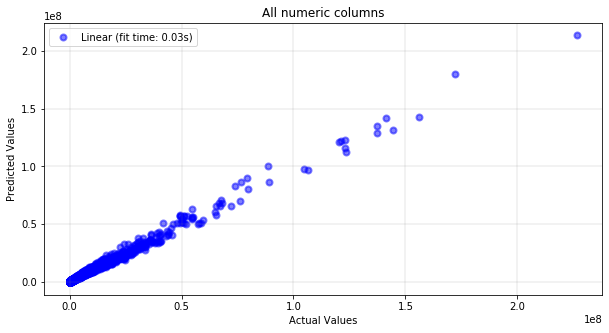


                                    Linear
Coefficient of determination  9.908231e-01
Mean Squared Error            1.230722e+12
Root Mean Squared Error       1.109379e+06
Residual sum of squares       1.230722e+12


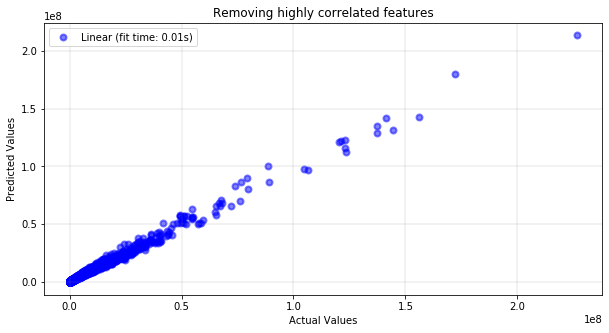

In [36]:
lw = 2
results = pd.DataFrame([], ['Coefficient of determination', 'Mean Squared Error', 'Root Mean Squared Error', 'Residual sum of squares'])
for titlePlot, X_train, y_train, X_test, y_test in parameters:
    plt.figure(figsize=(10,5))
    t0 = time.time()
    estimator = LinearRegression()
    estimator.fit(X_train, y_train)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(X_test)
    results['Linear'] = [r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), np.mean((y_pred-y_test)**2)]
    plt.scatter(y_test, y_pred, color='blue', linewidth=lw, alpha=0.5, label='%s (fit time: %.2fs)' % ('Linear', elapsed_time))
    print("=================================================================================\n")
    print(results)
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
    plt.legend(loc='upper left')
    plt.title(titlePlot)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

From the plots and the tables we can see that the second split performed slightly better than the first with a coef. of determination `0.9908231`


                                Huber 1.35     Huber 1.5    Huber 1.75  \
Coefficient of determination  9.896442e-01  9.896442e-01  9.899849e-01   
Mean Squared Error            1.388820e+12  1.388820e+12  1.343127e+12   
Root Mean Squared Error       1.178482e+06  1.178482e+06  1.158934e+06   
Residual sum of squares       1.388820e+12  1.388820e+12  1.343127e+12   

                                 Huber 1.9  
Coefficient of determination  9.896442e-01  
Mean Squared Error            1.388820e+12  
Root Mean Squared Error       1.178482e+06  
Residual sum of squares       1.388820e+12  


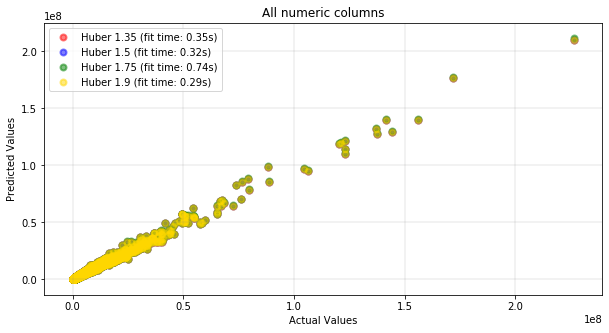


                                Huber 1.35     Huber 1.5    Huber 1.75  \
Coefficient of determination  9.896442e-01  9.899850e-01  9.896697e-01   
Mean Squared Error            1.388820e+12  1.343111e+12  1.385398e+12   
Root Mean Squared Error       1.178482e+06  1.158926e+06  1.177029e+06   
Residual sum of squares       1.388820e+12  1.343111e+12  1.385398e+12   

                                 Huber 1.9  
Coefficient of determination  9.896442e-01  
Mean Squared Error            1.388820e+12  
Root Mean Squared Error       1.178482e+06  
Residual sum of squares       1.388820e+12  


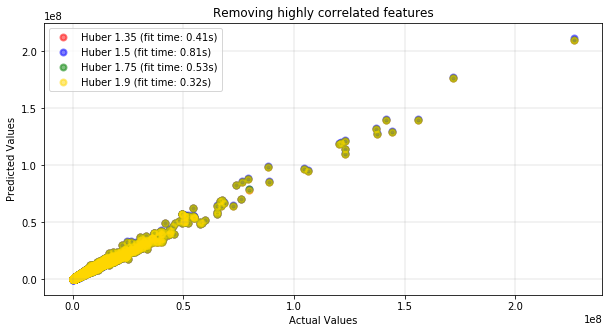

In [37]:
estimators = [('Huber 1.35', HuberRegressor(epsilon=1.35)),
              ('Huber 1.5', HuberRegressor(epsilon=1.5)),
              ('Huber 1.75', HuberRegressor(epsilon=1.75)),
              ('Huber 1.9', HuberRegressor(epsilon=1.9))]
colors = {'Huber 1.35': 'red', 'Huber 1.5': 'blue', 'Huber 1.75': 'green', 'Huber 1.9': 'gold'}
lw = 2
results = pd.DataFrame([], ['Coefficient of determination', 'Mean Squared Error', 'Root Mean Squared Error', 'Residual sum of squares'])
for titlePlot, X_train, y_train, X_test, y_test in parameters:
    plt.figure(figsize=(10,5))
    for name, estimator in estimators:
        t0 = time.time()
        estimator.fit(X_train, y_train)
        elapsed_time = time.time() - t0
        y_pred = estimator.predict(X_test)
        results[name] = [r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), np.mean((y_pred-y_test)**2)]
        plt.scatter(y_test, y_pred, color=colors[name], linewidth=lw, alpha=0.5, label='%s (fit time: %.2fs)' % (name, elapsed_time))
    print("=================================================================================\n")
    print(results)
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
    plt.legend(loc='upper left')
    plt.title(titlePlot)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

In the first split the algorithm performed slightly better in terms of accuracy but in the second split without highly correlated features, it was a bit faster. 
We can say that the best result was obtained when the model was trained with the first split with `epsilon=1.9`.

==============================RandomForestRegressor==============================


                                     50-10         50-05        150-10  \
Coefficient of determination  9.885151e-01  9.881822e-01  9.889098e-01   
Mean Squared Error            1.540239e+12  1.584886e+12  1.487314e+12   
Root Mean Squared Error       1.241064e+06  1.258922e+06  1.219555e+06   
Residual sum of squares       1.540239e+12  1.584886e+12  1.487314e+12   

                                    150-05        300-10        300-05  
Coefficient of determination  9.879917e-01  9.887756e-01  9.877091e-01  
Mean Squared Error            1.610434e+12  1.505303e+12  1.648333e+12  
Root Mean Squared Error       1.269029e+06  1.226908e+06  1.283874e+06  
Residual sum of squares       1.610434e+12  1.505303e+12  1.648333e+12  


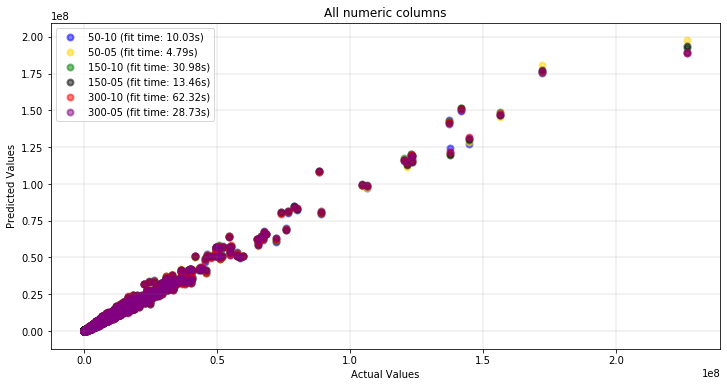


                                     50-10         50-05        150-10  \
Coefficient of determination  9.893665e-01  9.891180e-01  9.886722e-01   
Mean Squared Error            1.426061e+12  1.459384e+12  1.519175e+12   
Root Mean Squared Error       1.194178e+06  1.208050e+06  1.232548e+06   
Residual sum of squares       1.426061e+12  1.459384e+12  1.519175e+12   

                                    150-05        300-10        300-05  
Coefficient of determination  9.880441e-01  9.885900e-01  9.878277e-01  
Mean Squared Error            1.603415e+12  1.530194e+12  1.632427e+12  
Root Mean Squared Error       1.266260e+06  1.237010e+06  1.277665e+06  
Residual sum of squares       1.603415e+12  1.530194e+12  1.632427e+12  


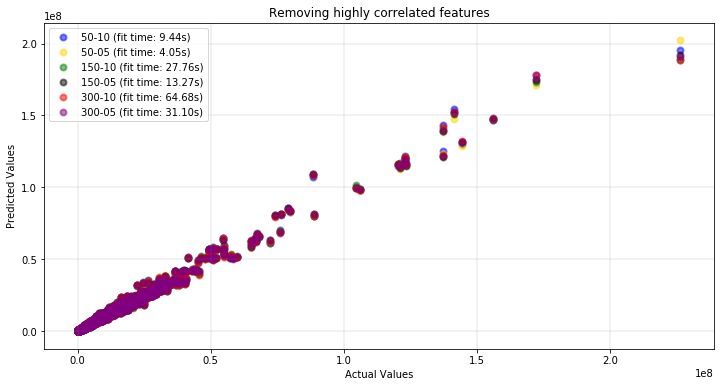

In [38]:
print("==============================RandomForestRegressor==============================\n")
estimators = [("50-10", RandomForestRegressor(n_estimators=50, max_depth=10, random_state=randNum)),
              ("50-05", RandomForestRegressor(n_estimators=50, max_depth=5, random_state=randNum)),
              ("150-10", RandomForestRegressor(n_estimators=150, max_depth=10, random_state=randNum)),
              ("150-05", RandomForestRegressor(n_estimators=150, max_depth=5, random_state=randNum)),
              ("300-10", RandomForestRegressor(n_estimators=300, max_depth=10, random_state=randNum)),
              ("300-05", RandomForestRegressor(n_estimators=300, max_depth=5, random_state=randNum))]
results = pd.DataFrame([], ['Coefficient of determination', 'Mean Squared Error', 'Root Mean Squared Error', 'Residual sum of squares'])
colors = {'50-10': 'blue', '50-05': 'gold', '150-10': 'green', '150-05': 'black', '300-10': 'red', '300-05': 'purple'}
lw = 2
for titlePlot, X_train, y_train, X_test, y_test in parameters:
    plt.figure(figsize=(12, 6))
    for name, estimator in estimators:
        t0 = time.time()
        estimator.fit(X_train, y_train)
        elapsed_time = time.time() - t0
        y_pred = estimator.predict(X_test)
        results[name] = [r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), np.mean((y_pred-y_test)**2)]
        plt.scatter(y_test, y_pred, color=colors[name], linewidth=lw, alpha=0.5, label='%s (fit time: %.2fs)' % (name, elapsed_time))
    print("=================================================================================\n")
    print(results)
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
    plt.legend(loc='upper left')
    plt.title(titlePlot)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

In the first split the best result taken from Random Forest Regressor was when the parameters were `n_estimator=150` and `max_depth=10`.
In second split the best result taken from Random Forest Regressor was when the parameters were `n_estimator=50` and `max_depth=10`.
Overall the best result in terms of accuracy and performance was latter mentioned, with coef. of determintation `0.989`.

Before training the model using SVR we will first normalize it with `MinMaxScaler`.

In [39]:
X_numeric = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X_numeric), columns=X_numeric.columns)
X_train_numeric, X_test_numeric, y_train_numeric, y_test_numeric = train_test_split(X_numeric, y, test_size=0.25, random_state=randNum)

X_remove_high_corr = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X_remove_high_corr), columns=X_remove_high_corr.columns)
X_train_remove_high_corr, X_test_remove_high_corr, y_train_remove_high_corr, y_test_remove_high_corr = train_test_split(X_remove_high_corr, y, test_size=0.25, random_state=randNum)


                                   Rbf 1e6       Rbf 1e9
Coefficient of determination  7.689244e-01  9.740461e-01
Mean Squared Error            3.098966e+13  3.480687e+12
Root Mean Squared Error       5.566835e+06  1.865660e+06
Residual sum of squares       3.098966e+13  3.480687e+12


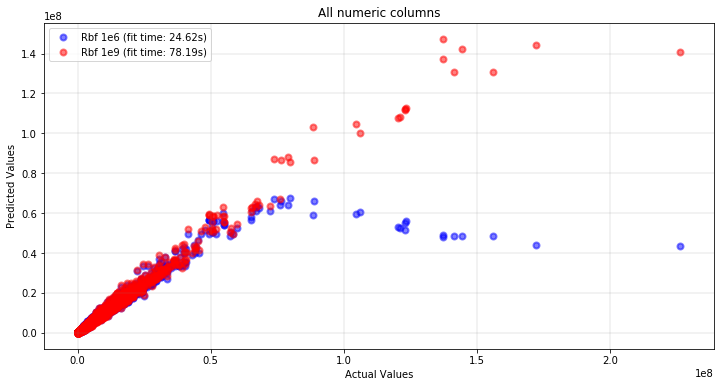


                                   Rbf 1e6       Rbf 1e9
Coefficient of determination  7.689073e-01  9.740412e-01
Mean Squared Error            3.099195e+13  3.481346e+12
Root Mean Squared Error       5.567041e+06  1.865837e+06
Residual sum of squares       3.099195e+13  3.481346e+12


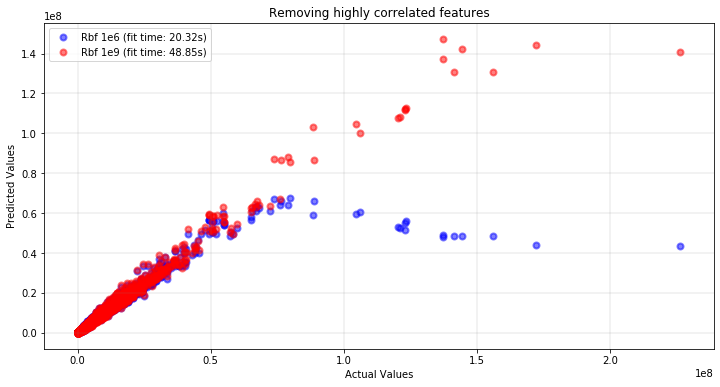

In [40]:
svr_regressors = [("Rbf 1e6", SVR(kernel='rbf', C=1e6, cache_size=500)),
                  ("Rbf 1e9", SVR(kernel='rbf', C=1e9, cache_size=500))]
colors = {"Rbf 1e6": "blue", "Rbf 1e9": "red"}
lw = 2
results = pd.DataFrame([], ['Coefficient of determination', 'Mean Squared Error', 'Root Mean Squared Error', 'Residual sum of squares'])
for titlePlot, X_train, y_train, X_test, y_test in parameters:
    plt.figure(figsize=(12, 6))
    for name, estimator in svr_regressors:
        t0 = time.time()
        estimator.fit(X_train, y_train)
        elapsed_time = time.time() - t0
        y_pred = estimator.predict(X_test)
        results[name] = [r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), np.mean((y_pred-y_test)**2)]
        plt.scatter(y_test, y_pred, color=colors[name], linewidth=lw, alpha=0.5, label='%s (fit time: %.2fs)' % (name, elapsed_time))
    print("=================================================================================\n")
    print(results)
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
    plt.legend(loc='upper left')
    plt.title(titlePlot)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

From the tables below we can see that in the first split, with All numeric features, *Rbf kernel* performed better when `C=1e9`. The same we can say also for the second split. However, the best result was obtained from the first split with `coef. of determination 0.974`.